In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import mlgrad.models as models
import mlgrad.funcs as funcs
import mlgrad.avragg as avragg
import mlgrad.loss as loss
import mlgrad.regr as regr
import mlgrad.plots as plots
import mlgrad.inventory as inventory
import mlgrad.af as af

import sys
print(sys.version)

3.13.5 (main, Jun 25 2025, 18:55:22) [GCC 14.2.0]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', index_col='id')
df.head()

,log.Te,log.light
id,,
1,4.37,5.23
2,4.56,5.74
3,4.26,4.93
4,4.56,5.74
5,4.30,5.19


In [3]:
X = log_Te = df["log.Te"].values
Y = log_light = df["log.light"].values
Xs = X[:,None]
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
N = len(X)
print((N-7)/N)

0.851063829787234


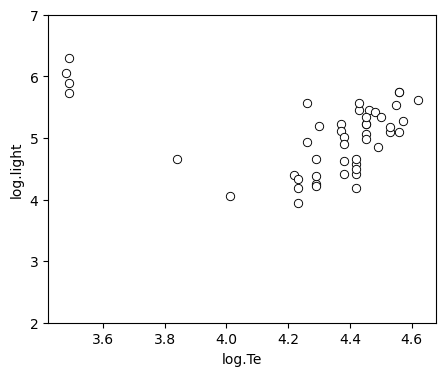

In [4]:
plt.figure(figsize=(5,4))
plt.scatter(log_Te, log_light, s=36, c='w', edgecolors='k', linewidth=0.66)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.ylim(2, 7)
plt.show()

In [5]:
mod_ls = models.LinearModel(1)
mod_r = models.LinearModel(1)
mod_m = models.LinearModel(1)
mod_wm = models.LinearModel(1)
mod_wmz = models.LinearModel(1)
mod_wmm = models.LinearModel(1)
mod_ls2 = models.LinearModel(1)

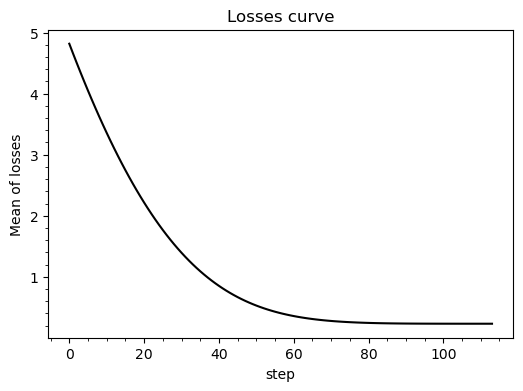

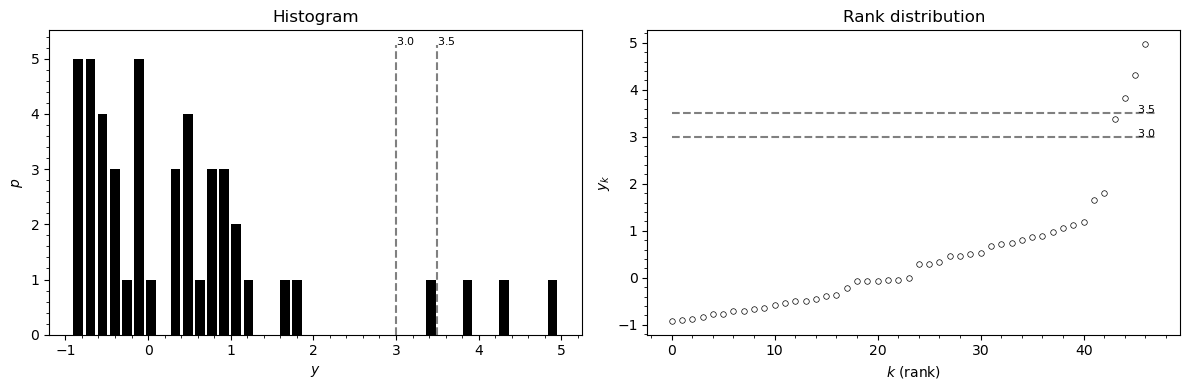

In [6]:
regr_ls = regr.regression(Xs, Y, mod_ls, h=0.01, tol=1.0e-6, n_iter=1000)
plots.plot_losses(regr_ls)
err_ls = abs(mod_ls.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_ls), levels=[3.0, 3.5])

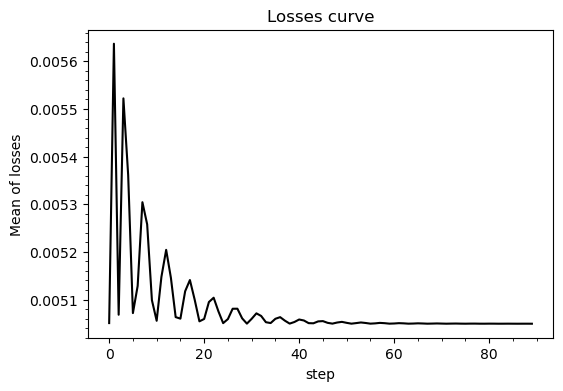

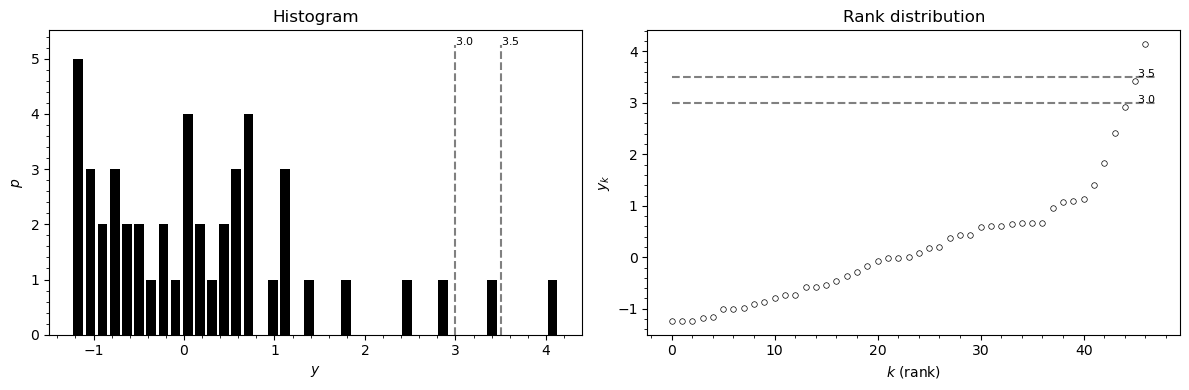

In [7]:
regr_r = regr.r_regression_irls(Xs, Y, mod_r, funcs.SoftAbs_Sqrt(0.001), h=0.01, n_iter=1000)
plots.plot_losses(regr_r)
err_r = abs(mod_r.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_r), levels=[3.0, 3.5])

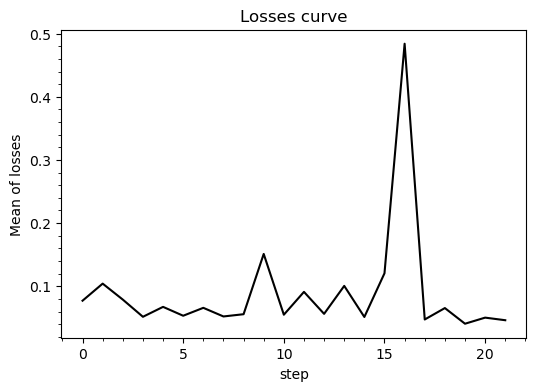

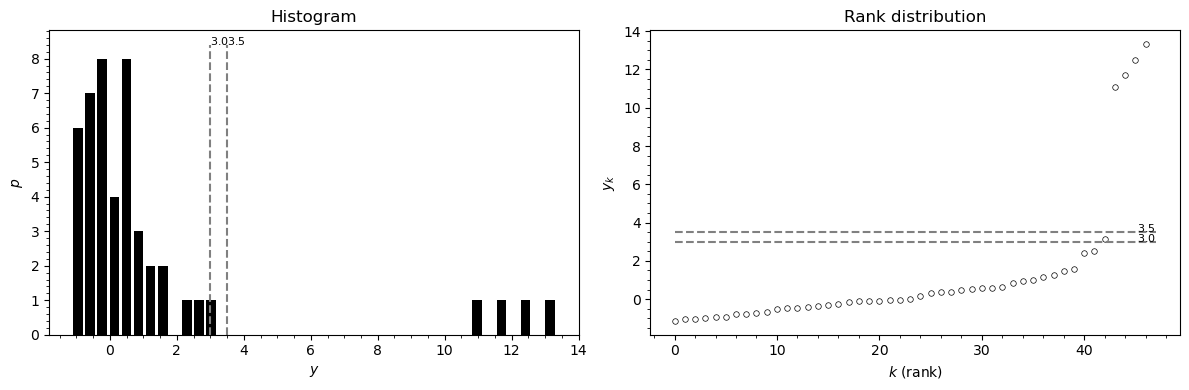

In [8]:
avrfunc_m = af.averaging_function("M", funcs.SoftAbs_Sqrt(0.001))
regr_m = regr.m_regression_irls(Xs, Y, mod_m, 
                                agg_func=avrfunc_m, h=0.01, n_iter=2000)
plots.plot_losses(regr_m)
err_m = abs(mod_m.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_m), levels=[3.0, 3.5])

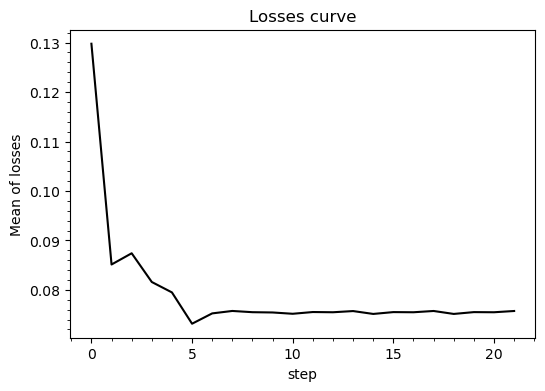

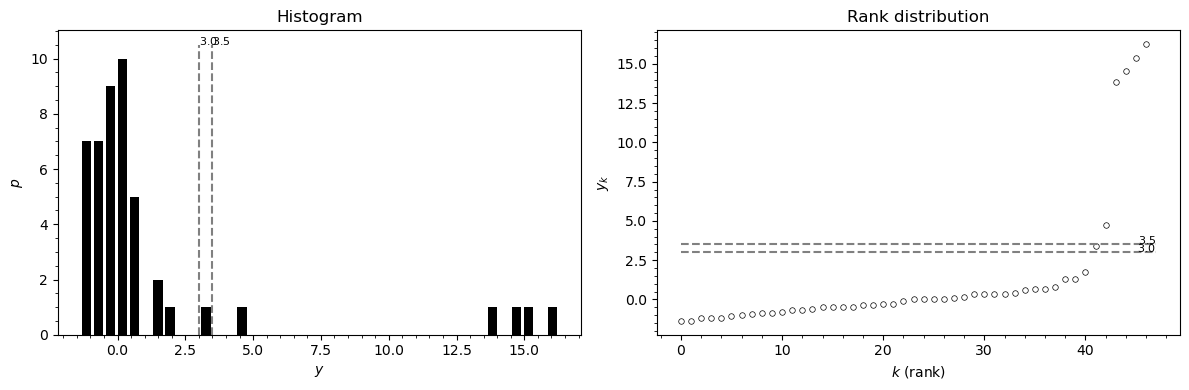

[-8.035  2.929]


In [9]:
avrfunc_wm = regr.averaging_function("WM", funcs.QuantileFunc(0.84, funcs.SoftAbs_Sqrt(0.001)))
regr_wm = regr.m_regression_irls(Xs, Y, mod_wm, 
                                 agg_func=avrfunc_wm, h=0.01, n_iter=1000)
plots.plot_losses(regr_wm)
err_wm = abs(mod_wm.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_wm), levels=[3.0, 3.5])
print(np.asarray(mod_wm.param))

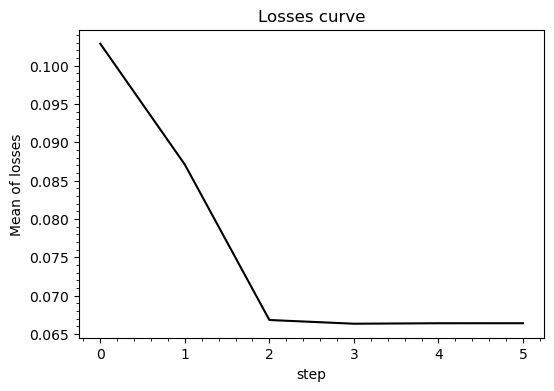

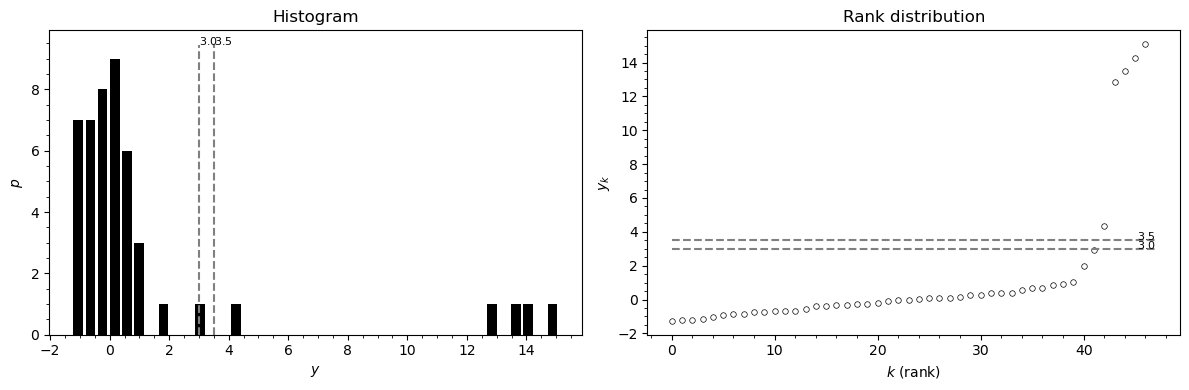

[-8.356  3.021]


In [10]:
avrfunc_wmz = regr.averaging_function("WMZ", funcs.QuantileFunc(0.84, funcs.SoftAbs_Sqrt(0.001)), kwds={"alpha":3.5})
regr_wmz = regr.m_regression_irls(Xs, Y, mod_wmz, 
                                 agg_func=avrfunc_wmz, h=0.01, n_iter=1000)
plots.plot_losses(regr_wmz)
err_wmz = abs(mod_wmz.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_wmz), levels=[3.0, 3.5])
print(np.asarray(mod_wmz.param))

In [11]:
# avrfunc_s = regr.scaling_function("S", func.Sqrt(0.001))
# regr_ms = regr.m_regression_irls(log_Te[:,None], log_light, mod_m, 
#                                 agg_func=avrfunc_s, h=0.001, n_iter=1000)
# regr.plot_losses_and_errors(regr_ms, log_Te[:,None], log_light, logscale=False)
# print(avrfunc_s.u)

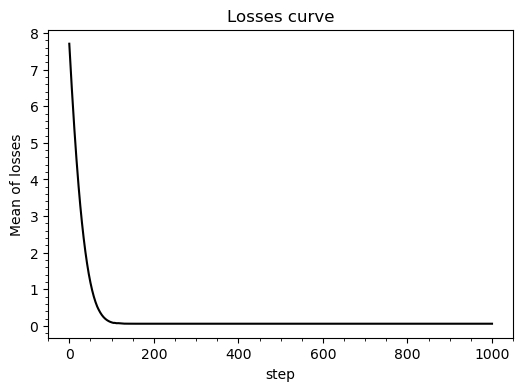

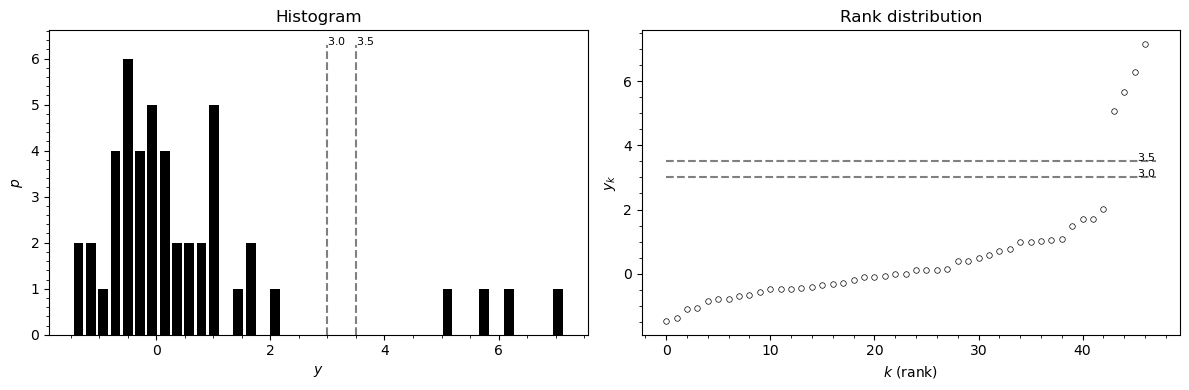

[1.037 0.844]


In [12]:
avrfunc_wmm = regr.averaging_function("WM", funcs.QuantileFunc(0.5, funcs.SoftAbs_Sqrt(0.001)))
regr_wmm = regr.m_regression(Xs, Y, mod_wmm, 
                                 agg_func=avrfunc_wmm, h=0.01, n_iter=1000)
plots.plot_losses(regr_wmm)
err_wmm = abs(mod_wmm.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_wmm), levels=[3.0, 3.5])
print(np.asarray(mod_wmm.param))

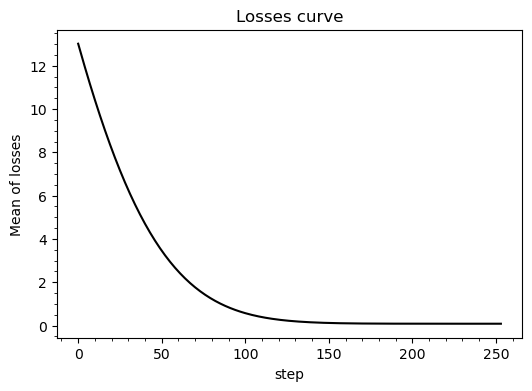

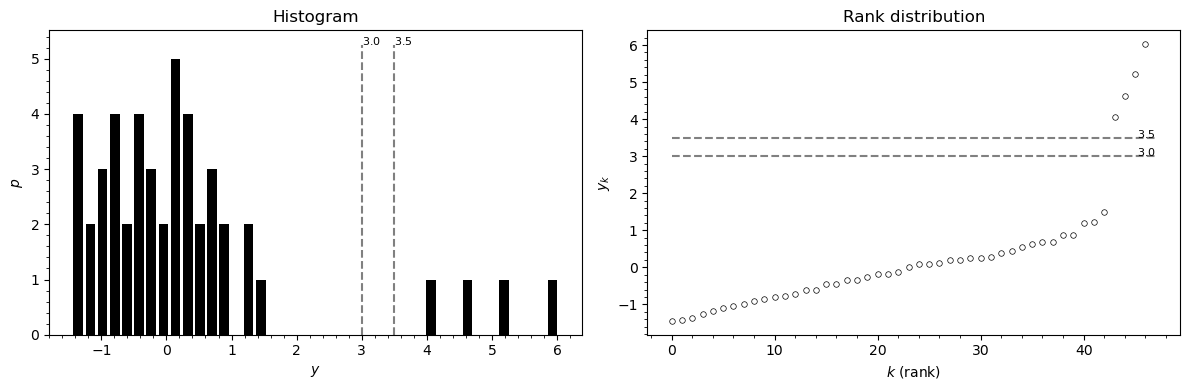

In [13]:
X_wo, Y_wo = regr.exclude_outliers(mod_wm, X, Y, 7)
regr_ls2 = regr.regression(X_wo[:,None], Y_wo, mod_ls2, h=0.01, n_iter=3000)
plots.plot_losses(regr_ls2)
err_ls2 = abs(mod_ls2.evaluate(Xs) - Y)
plots.plot_hist_and_rank_distribution(inventory.modified_zscore(err_ls2), levels=[3.0, 3.5])

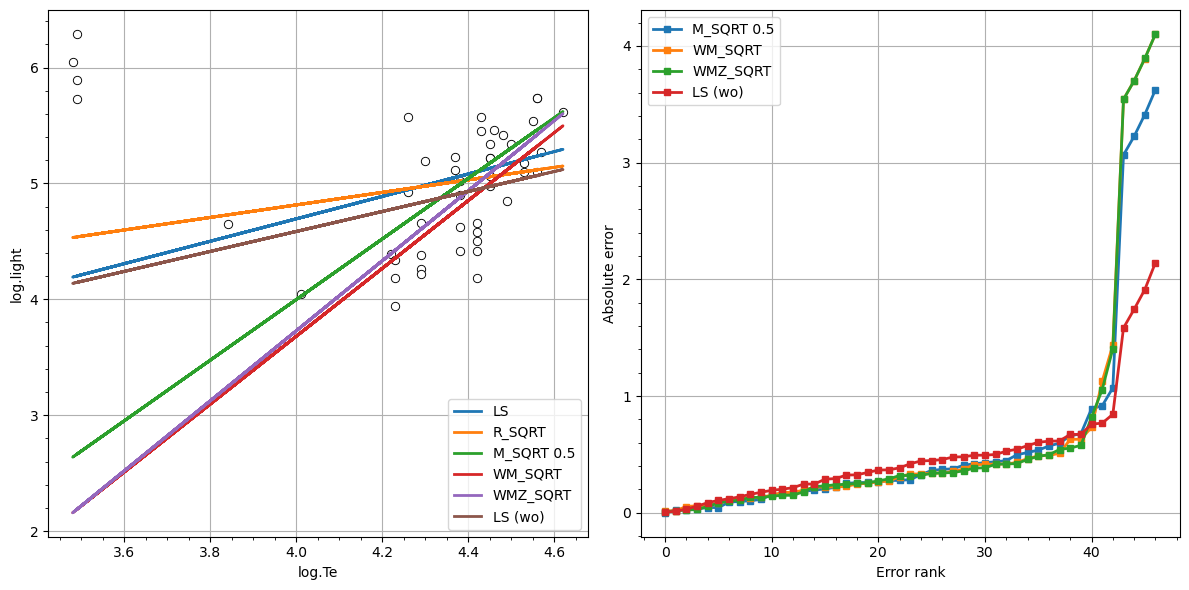

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(log_Te, log_light, s=36, c='w', edgecolors='k', linewidth=0.66)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.plot(X[:,None], mod_ls.evaluate_all(X[:,None]), label='LS', linewidth=2.)
plt.plot(X[:,None], mod_r.evaluate_all(X[:,None]), label='R_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_m.evaluate_all(X[:,None]), label='M_SQRT 0.5', linewidth=2.)
plt.plot(X[:,None], mod_wm.evaluate_all(X[:,None]), label='WM_SQRT', linewidth=2.)
# plt.plot(X[:,None], mod_wmr.evaluate_all(X[:,None]), label='WMR_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_wmz.evaluate_all(X[:,None]), label='WMZ_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_ls2.evaluate_all(X[:,None]), label='LS (wo)', linewidth=2.)
plt.legend()
plt.minorticks_on()
plt.grid(1)
plt.subplot(1,2,2)
# plt.plot(sorted(np.abs(Y-mod_ls.evaluate_all(X[:,None]))), label='LS', linewidth=2., marker='s', markersize=4)
# plt.plot(sorted(np.abs(Y-mod_r.evaluate_all(X[:,None]))), label='R_SQRT', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_m.evaluate_all(X[:,None]))), label='M_SQRT 0.5', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_wm.evaluate_all(X[:,None]))), label='WM_SQRT', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_wmz.evaluate_all(X[:,None]))), label='WMZ_SQRT', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_ls2.evaluate_all(X[:,None]))), label='LS (wo)', linewidth=2., marker='s', markersize=4)
plt.legend()
plt.minorticks_on()
plt.xlabel('Error rank')
plt.ylabel('Absolute error')
plt.grid(1)
plt.tight_layout()
plt.show()